In [3]:
%matplotlib inline

###KAUFMAN LAB LIBRARY
klib_version = '1.1'

import sys
sys.path.append('klab_python_lib_Yb/')

import klib
if klib.__version__ != klib_version:
    raise ValueError('Incorrect klib version number.')

from klib.imports import *
from klib.analysis import *
from klib.plotutil import *

# from vimba import *
from IPython import display

%load_ext autoreload
%aimport klib
%autoreload

In [5]:
from ctypes import *
import pythoncom

gmoogLib = cdll.LoadLibrary('B:/Yb heap\Experiment_code_Yb/tweezer_balance/tweezer_balance/gmoogLibUDP/x64/Release/gmoogLib.dll')

class GM_python(object):
    def __init__(self):
        gmoogLib.gm_new.argtypes = []
        gmoogLib.gm_new.restype = c_void_p
        
        gmoogLib.gm_test.argtypes = [c_void_p]
        gmoogLib.gm_test.restype = c_int
        
        gmoogLib.gm_zeroAll.argtypes = [c_void_p]
        gmoogLib.gm_zeroAll.restype = c_void_p
        
        gmoogLib.gm_endMessage.argtypes = [c_void_p]
        gmoogLib.gm_endMessage.restype = c_void_p
        
        gmoogLib.gm_setDAC.argtypes = [c_void_p, c_int, c_int, POINTER(c_float), POINTER(c_float), POINTER(c_float)]
        gmoogLib.gm_setDAC.restype = c_void_p
        
        self.obj = gmoogLib.gm_new()
    
    def test(self):
        gmoogLib.gm_test(self.obj)
    def zeroAll(self):
        gmoogLib.gm_zeroAll(self.obj)
    def endMessage(self):
        gmoogLib.gm_endMessage(self.obj)
    def setDAC(self, dac, channels, freqs, amps, phases):
        gmoogLib.gm_setDAC(self.obj, dac, channels, freqs, amps, phases)

gmoog = GM_python()

In [6]:
def getImg(camObj, crop_coords = None):
    frame = camObj.get_frame()
    img = frame.as_numpy_ndarray()[:,:,0]
    if crop_coords is not None:
        img = img[crop_coords[0]:crop_coords[1],crop_coords[2]:crop_coords[3]]
    return img

def getROIs(img, bigRoiSettings = [360, 200, 100], roiSettings = [4, 8, 50], bgoff = (165,165)):
    # parse image
    bigRoi = find_rois(img, *bigRoiSettings, bgoff, display = False)[0][0]
    img = img[bigRoi[2]:bigRoi[3],bigRoi[0]:bigRoi[1]]

    rois, bgrois = find_rois(img, *roiSettings, bgoff)
    
    return bigRoi, rois

def getNewAmps(img, ampsetD0, ampsetD1, freqsetD0, freqsetD1, phaseset0, phaseset1, masks, DACoffset = 0, method = 'cross', bgoff = (165,165), ampscale = .01, double = False):
    
    n0 = len(freqsetD0)
    n1 = len(freqsetD1)
    
    ampset100_0 = np.ones(n0)*100
    ampset100_1 = np.ones(n1)*100
    
#     bigRoi = find_rois(img, *bigRoiSettings, bgoff, display = False)[0][0]
#     img = img[crop_coords[0]:crop_coords[1],crop_coords[2]:crop_coords[3]]

#     rois, bgrois = find_rois(img, *roiSettings, bgoff)

#     roisums = np.array(list(map(lambda roi: get_roi_sum(img, roi, bgoff, display=False, bgsub = True),rois)))
    roisums = np.array(list(map(lambda mask: np.sum(mask*img), masks)))

    # roi = rois[0]
    # iimg = img[roi[2]:roi[3],roi[0]:roi[1]]

    # fitdat, params, perr = gaussianBeamFit2D(iimg)
    # plt.imshow(iimg)
    # plt.contour(fitdat)
    # plt.show()

#     Plot ROIS for verification
    
#     plt.plot(roisums, 'ko')
#     # plt.axis([-.1, 11.1, 0, 1.1*max(roisums)])
#     plt.xlabel('spot number')
#     plt.ylabel('brightness')
#     plt.axhline(y=np.mean(roisums))
#     plt.show()

    if DACoffset==0:
        sign = 1 # for dac 0, 1
    elif DACoffset==2:
        sign = -1 # for dac 2, 3
    else:
        raise ValueError('Invalid DAC offset.')
        
    err = (roisums.reshape((n1,n0))[::-sign,:]-roisums.mean())/roisums.mean()*100
    maxerr = np.max(np.abs(err))
    fig=plt.figure()
    plt.imshow(err)
    plt.xlabel("DAC 0")
    plt.ylabel("DAC 1")
    plt.title('Mean val:'+str(np.mean(roisums)))
    cbar = plt.colorbar()
    cbar.set_label('Fractional offset (%)')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    fig.clear()
#     plt.show()
    
    if method == 'cross':
        roisumsD0 = roisums.reshape((n1,n0))[n0//2,::sign]  #DAC0
        roisumsD1 = roisums.reshape((n1,n0))[::-sign,n1//2]  #DAC1    
        
    elif method == 'mean':
        roisumsD0 = np.mean(roisums.reshape((n1,n0))[:, ::sign], axis = 0)  #DAC0
        roisumsD1 = np.mean(roisums.reshape((n1,n0))[::-sign,:], axis = 1)  #DAC1
    
    elif method == 'randomCross':
        roisumsD0 = roisums.reshape((n1,n0))[np.random.randint(n1),::sign]  #DAC0
        roisumsD1 = roisums.reshape((n1,n0))[::-sign,np.random.randint(n0)]  #DAC1    

    else:
        raise ValueError('Invalid method selection: ' + method)
    
    ampoutD0 = ampsetD0 - (roisumsD0-np.mean(roisumsD0))*ampscale
    ampoutD1 = ampsetD1 - (roisumsD1-np.mean(roisumsD1))*ampscale
    
    ampMax = np.max([np.max(ampoutD0), np.max(ampoutD1)])
    if ampMax > 100:
        ampoutD0 = ampoutD0 - (ampMax - 100)
        ampoutD1 = ampoutD1 - (ampMax - 100)
    
    ampMin = np.min([np.min(ampoutD0), np.min(ampoutD1)])
    if ampMin < 0:
        ampoutD0 = ampoutD0 - (ampMin)
        ampoutD1 = ampoutD1 - (ampMin)
    
    #     Send new values to GMoog
        
    gmoog.zeroAll()
    
    if double:
#         amp100_0 = np.ones(n0)*100
#         amp100_1 = np.ones(n1)*100
        ##more conservative, don't start at 100.
        amp100_0 = np.ones(n0)*80
        amp100_1 = np.ones(n1)*80

        seq0 = c_float * (2 * n0)
        seq1 = c_float * (2 * n1)
        
        freqsetDD0 = np.concatenate((freqsetD0,freqsetD0))
        freqsetDD1 = np.concatenate((freqsetD1,freqsetD1))

        ampsetDD0 = np.concatenate((amp100_0, ampsetD0))
        ampsetDD1 = np.concatenate((amp100_1, ampsetD1))

        phasesetD0 = np.concatenate((phaseset0,phaseset0))
        phasesetD1 = np.concatenate((phaseset1,phaseset1))
        gmoog.setDAC(0+DACoffset, 2*n0, seq0(*freqsetDD0), seq0(*ampsetDD0), seq0(*phasesetD0))
        gmoog.setDAC(1+DACoffset, 2*n1, seq1(*freqsetDD1), seq1(*ampsetDD1), seq1(*phasesetD1))
    
    else:
        seq0 = c_float * n0
        seq1 = c_float * n1
        gmoog.setDAC(0+DACoffset, n0, seq0(*freqsetD0), seq0(*ampsetD0), seq0(*phaseset0))
        gmoog.setDAC(1+DACoffset, n1, seq1(*freqsetD1), seq1(*ampsetD1), seq1(*phaseset1))
        
    gmoog.endMessage()
    
    time.sleep(.2)
    
    return ampoutD0, ampoutD1, maxerr

# Balancing

In [8]:
%autoreload

plt.rcParams['figure.figsize'] = (10,10)

# Starting point for generating tones

##813

# numtones0 = 16
# numtones1 = 20

# bgoff = (165, 165)

# DACoffset = 2
# amp_guessD0 = 70
# amp_guessD1 = 70

# lincorr0 = 0
# lincorr1 = 0

# freqcenterD0 = 180+3-0.5
# spacingD0 = 5*0.6377
# freqcenterD1 = 190+.2
# spacingD1 = 4*0.6377

##813 NEW 210220

# numtones0 = 3
# numtones1 = 3

# bgoff = (165, 165)

# DACoffset = 2
# amp_guessD0 = 10
# amp_guessD1 = 40

# lincorr0 = 0
# lincorr1 = 0

# latspacing = 5.6575*(30/29+1/128)/3*0.6377

# freqcenterD0 = 180
# freqcenterD1 = 180

# freqcenterD0 = 180+3-0.5
# freqcenterD1 = 190+.2-5*.6377

# spacingD0 = latspacing*11
# spacingD1 = latspacing*11

# ###515

# numtones0 = 16
# numtones1 = 24
# numtones0 = 8
# numtones1 = 8

# numtones0 = 17
# numtones1 = 1

numtones0 = 1
numtones1 = 1

bgoff = (165, 165)

DACoffset = 0
amp_guessD0 = 90
amp_guessD1 = 75
# amp_guessD0 = 98
# amp_guessD1 = 98
# amp_guessD0 = 50
# amp_guessD1 = 50

lincorr0 = 1
lincorr1 = 1

# # freqcenterD0 = 180
# # spacingD0 = 60 # 4.5 #10
# # freqcenterD1 = 180
# # spacingD1 = 65 # 4 #16

latspacing = 5.6575*(30/29+1/128)/3

freqcenterD0 = 130
# freqcenterD0 = 183
spacingD0 = latspacing*3*0.97913226
# spacingD0 = latspacing*11*0.97913226 #0.98353589

freqcenterD1 = 130
# freqcenterD1 = 164
spacingD1 = latspacing*2*1.00835695
# spacingD1 = latspacing*11*1.00835695 #1.00558151

###

# offset = 1.3
double = False #BE VERY CAREFUL - CAN QUADRUPLE EXPECTED OUTPUT POWER IF SET TO TRUE.
camID = 2
exposure = 100
# exposure = 5000
# exposure = 2000

#####################
# if len(roisums) > numtones:
#     roisums = roisums[::2]

tone_inds0 = np.arange(numtones0)
tone_inds1 = np.arange(numtones1)

freqsD0 = np.arange(freqcenterD0-spacingD0*(numtones0-1)/2, freqcenterD0+spacingD0*numtones0/2, spacingD0)
freqsD1 = np.arange(freqcenterD1-spacingD1*(numtones1-1)/2, freqcenterD1+spacingD1*numtones1/2, spacingD1)

###DANGER - SETTING FREQUENCIES MANUALLY
# freqsD0 = arr([-13.7885+1,0,13.7885-1])+180
# freqsD1 = arr([-13.7885-1,0,13.7885+1])+186
###

phases0 = np.pi*((tone_inds0+1)**2)/(numtones0)
phases1 = np.pi*((tone_inds1+1)**2)/(numtones1)

phase_degs0 = np.round(phases0*180/np.pi%360, 1)
phase_degs1 = np.round(phases1*180/np.pi%360, 1)

ampscale = .001

init_ampsD0 = np.ones(numtones0)*amp_guessD0 + (np.arange(numtones0)-numtones0/2)*lincorr0
init_ampsD1 = np.ones(numtones1)*amp_guessD1 + (np.arange(numtones1)-numtones1/2)*lincorr1

# init_ampsD0[:3]/=2.5
# init_ampsD1[:3]/=2.5

ampD0 = init_ampsD0
ampD1 = init_ampsD1
err = 50

seq0 = c_float * numtones0
seq1 = c_float * numtones1

gmoog.zeroAll()

if double:
    amp100_0 = np.ones(numtones0)*80
    amp100_1 = np.ones(numtones1)*80
    
    seq0 = c_float * (2 * numtones0)
    seq1 = c_float * (2 * numtones1)
    freqsetDD0 = np.concatenate((freqsD0,freqsD0))
    freqsetDD1 = np.concatenate((freqsD1,freqsD1))

    ampsetDD0 = np.concatenate((amp100_0, ampD0))
    ampsetDD1 = np.concatenate((amp100_1, ampD1))

    phasesetD0 = np.concatenate((phase_degs0, phase_degs0))
    phasesetD1 = np.concatenate((phase_degs1, phase_degs1))
    gmoog.setDAC(0+DACoffset, 2*numtones0, seq0(*freqsetDD0), seq0(*ampsetDD0), seq0(*phasesetD0))
    gmoog.setDAC(1+DACoffset, 2*numtones1, seq1(*freqsetDD1), seq1(*ampsetDD1), seq1(*phasesetD1))
else:
    gmoog.setDAC(0+DACoffset, len(freqsD0), seq0(*freqsD0), seq0(*ampD0), seq0(*phase_degs0))
    gmoog.setDAC(1+DACoffset, len(freqsD1), seq1(*freqsD1), seq1(*ampD1), seq1(*phase_degs1))

gmoog.endMessage()

time.sleep(.2)

# cam_settings_file = "tweezer_monitor_singleFrame.xml"
# # crop_coords = arr([top, bottom, left, right])
# # crop_coords = arr([1480,1650,995,1175])
# # crop_coords = arr([1360,1650,925,1175])
# # crop_coords = arr([1460,1670,985,1195])
# # crop_coords = arr([1505,1670,1017,1195])
# # crop_coords = arr([1440,1700,975,1300])

# # 3x3
# # crop_coords = arr([1500,1675,1000,1195])

# # 16x16
# crop_coords = arr([1450,1675,978,1195])

# # 24x16
# # crop_coords = arr([1450,1675,980,1195])
# crop_coords = arr([1435,1670,970,1195])

# # 17x1
# # crop_coords = arr([1450+85,1450+85+25,958,1295])

# # 1x17
# crop_coords = arr([1400,1675,978,1195])

# # 15x15 tight
# # crop_coords = arr([1538,1670,1048,1195])

# # #for 813 big
# # crop_coords = arr([1500,1650,985,1115])

# with Vimba.get_instance() as vimba:
#     cams = vimba.get_all_cameras()
#     with cams[camID] as cam:
#         cam.load_settings(cam_settings_file, PersistType.All)
#         exposure_time = cam.ExposureTime
#         exposure_time.set(exposure)
#         img = getImg(cam,crop_coords)

# # imgc, crop_coords = klib.imagutil.crop(img, sigma = 5, offset = 1, coords = True, pad = 1, plots = True)
# # imgc, crop_coords = klib.imagutil.crop(img, sigma = 50, offset = 1, coords = True, pad=3, plots = True)
# imgc = img
# plt.figure()
# plt.imshow(imgc)
# plt.show()
# # masks = getMasks(imgc, fftN = 5000, N = [numtones0, numtones1], wmask = 8)*2
# # masks = getMasks(imgc, fftN = 5000, N = [numtones0, numtones1], wmask = 15, FFT = False)*2
# # masks = getMasks(imgc, fftN = 5000, N = [numtones0, numtones1], wmask = 2, mode = 'box')
# # masks = getMasks(imgc, fftN = 5000, N = [numtones0, numtones1], wmask = 3)*2
# # masks = getMasks(imgc, fftN = 10000, N = [numtones0, numtones1], wmask = 16, mode = 'box')

# masks = getMasks(imgc, fftN = 5000, N = [numtones0, numtones1], wmask = 3, FFT = False, mode = 'box')
# masks = masks[np.argsort(np.argmax(masks.reshape(26,-1), axis = 1))] # Quick fix for sorting when not using FFT

# if double:
#     for ind in tone_inds0:
#         print('set', "DAC"+str(0+DACoffset), ind, amp100_0[ind], freqsD0[ind], phase_degs0[ind])

#     print()

#     for ind in tone_inds1:
#         print('set', "DAC"+str(1+DACoffset), ind, amp100_1[ind], freqsD1[ind], phase_degs1[ind])
    
#     print()
    
#     for ind in tone_inds0:
#         print('set', "DAC"+str(0+DACoffset), ind + np.max(tone_inds0) + 1, ampD0[ind], freqsD0[ind], phase_degs0[ind])

#     print()

#     for ind in tone_inds1:
#         print('set', "DAC"+str(1+DACoffset), ind + np.max(tone_inds1) + 1, ampD1[ind], freqsD1[ind], phase_degs1[ind])

# else:    
#     for ind in tone_inds0:
#         print('set', "DAC"+str(0+DACoffset), ind, ampD0[ind], freqsD0[ind], phase_degs0[ind])

#     print()

#     for ind in tone_inds1:
#         print('set', "DAC"+str(1+DACoffset), ind, ampD1[ind], freqsD1[ind], phase_degs1[ind])

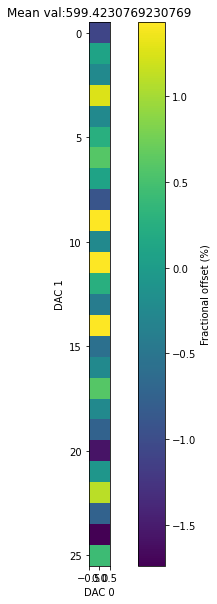

End


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [156]:
with Vimba.get_instance() as vimba:
    cams = vimba.get_all_cameras()
    with cams[camID] as cam:
        while err > 10:
            img = getImg(cam, crop_coords)
            ampD0, ampD1, err = getNewAmps(img, ampD0, ampD1, freqsD0, freqsD1, phase_degs0, phase_degs1, masks, method='mean', ampscale = 0.01, DACoffset = DACoffset, double = double)

        print('Switch mode')

        while err > 2:
            img = getImg(cam, crop_coords)
            ampD0, ampD1, err = getNewAmps(img, ampD0, ampD1, freqsD0, freqsD1, phase_degs0, phase_degs1, masks, method='randomCross', ampscale = 0.0065, DACoffset = DACoffset, double = double)

        print('End')

plt.close()

# Image with no balancing

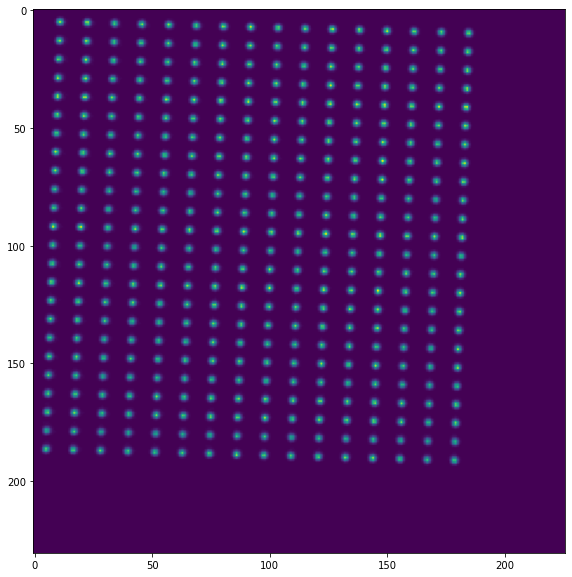

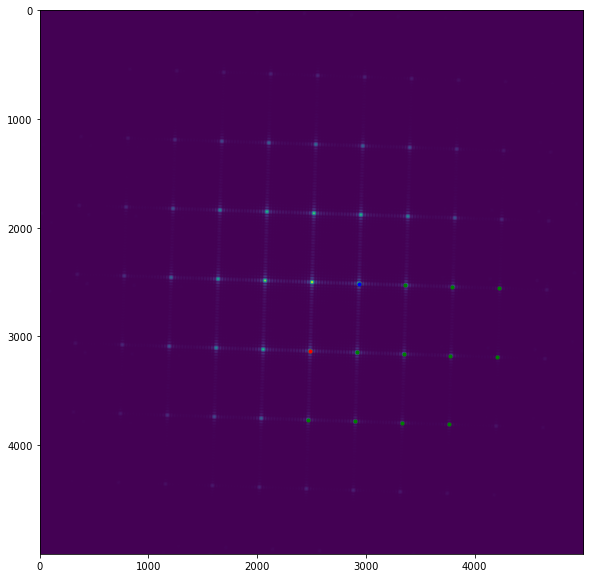

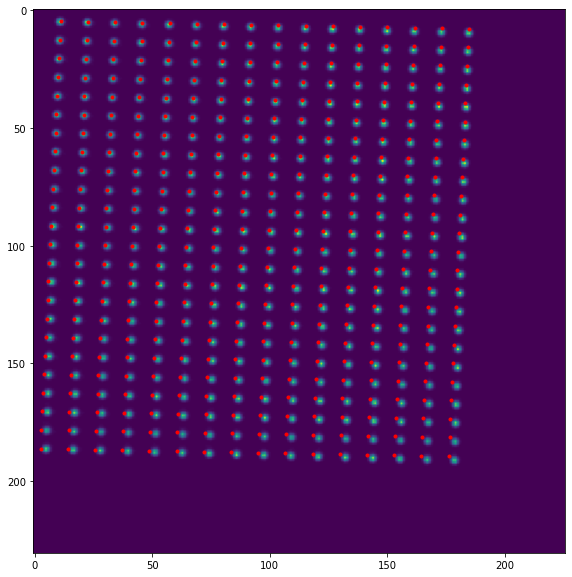

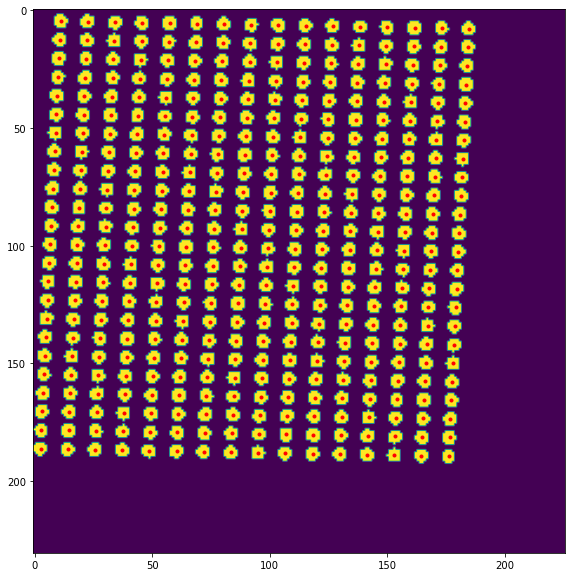

[ 7.89320112 -0.37469222] [ 0.2119817  11.56193127]
Mean val: 284.1822916666667


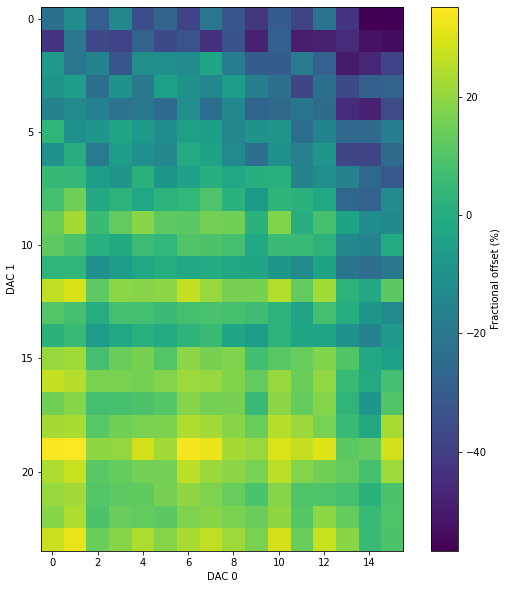

In [153]:
# camID = 2

exposure = 150
numtones0 = 16 #2
numtones1 = 24 # 2

crop_coords = arr([1439,1670,969,1195])

###

cam_settings_file = "tweezer_monitor_singleFrame.xml"
with Vimba.get_instance() as vimba:
    cams = vimba.get_all_cameras()
    with cams[camID] as cam:
        cam.load_settings(cam_settings_file, PersistType.All)
        exposure_time = cam.ExposureTime
        exposure_time.set(exposure)
        imgc = getImg(cam, crop_coords)
plt.imshow(imgc)
plt.show()

# imgc, crop_coords = klib.imagutil.crop(img, sigma = 3, offset = 1, coords = True, pad=3)
# imgc, crop_coords = klib.imagutil.crop(img, sigma = 25, offset = 1, coords = True, pad=3, plots = True)
# masks = getMasks(img, fftN = 2500, N = [numtones0, numtones1], wmask = 15)*2
# masks = getMasks(imgc, fftN = 5000, N = [numtones0, numtones1], wmask = 15, FFT = False)*2
masks = getMasks(imgc, fftN = 5000, N = [numtones0, numtones1], wmask = 3, mode = 'box', FFT = True)
# masks = getMasks(imgc, fftN = 10000, N = [numtones0, numtones1], wmask = 16, mode = 'box')
# masks = getMasks(imgc, fftN = 5000, N = [numtones0, numtones1], wmask = 1.5)*2

roisums = np.array(list(map(lambda mask: np.sum(mask*imgc), masks)))

print('Mean val:', np.mean(roisums))
plt.imshow((roisums.reshape((numtones1,numtones0))[::-1,:]-roisums.mean())/roisums.mean()*100)
# plt.imshow((roisums.reshape((numtones1,numtones0))[::-1,:])/roisums.max(),vmin=0, vmax = 1)
plt.xlabel("DAC 0")
plt.ylabel("DAC 1")
cbar = plt.colorbar()
cbar.set_label('Fractional offset (%)')
# cbar.set_label('Normalized depth')
plt.show()

In [28]:
tone_inds0_square = tone_inds0
ampD0_square = ampD0
freqsD0_square = freqsD0
phase_degs0_square = phase_degs0
tone_inds1_square = tone_inds1
ampD1_square = ampD1
freqsD1_square = freqsD1
phase_degs1_square = phase_degs1

In [52]:
if DACoffset==0:
    for ind in tone_inds0:
        print('set', "DAC"+str(0+DACoffset), ind, ampD0[ind], str(freqsD0[ind]) + '+xoff', phase_degs0[ind])
    print()
    for ind in tone_inds1:
        print('set', "DAC"+str(1+DACoffset), ind, ampD1[ind], str(freqsD1[ind]) + '+yoff', phase_degs1[ind])
        
elif DACoffset == 2:
    for ind in tone_inds0:
        print('set', "DAC"+str(0+DACoffset), ind, ampD0[ind], str(freqsD0[ind]) + '+xoff813', phase_degs0[ind])
    print()
    for ind in tone_inds1:
        print('set', "DAC"+str(1+DACoffset), ind, ampD1[ind], str(freqsD1[ind]) + '+yoff813', phase_degs1[ind])

set DAC0 0 94.30700000000003 128.81013727561304+xoff 10.6
set DAC0 1 74.5795 134.58387011616142+xoff 42.4
set DAC0 2 67.91999999999999 140.3576029567098+xoff 95.3
set DAC0 3 65.2155 146.13133579725817+xoff 169.4
set DAC0 4 64.93450000000007 151.90506863780655+xoff 264.7
set DAC0 5 65.01699999999998 157.67880147835493+xoff 21.2
set DAC0 6 65.61300000000001 163.4525343189033+xoff 158.8
set DAC0 7 67.61850000000001 169.22626715945168+xoff 317.6
set DAC0 8 69.4255 175.00000000000006+xoff 137.6
set DAC0 9 73.3405 180.77373284054843+xoff 338.8
set DAC0 10 74.09849999999997 186.5474656810968+xoff 201.2
set DAC0 11 78.06200000000005 192.3211985216452+xoff 84.7
set DAC0 12 79.0205 198.09493136219356+xoff 349.4
set DAC0 13 81.82100000000004 203.86866420274194+xoff 275.3
set DAC0 14 87.4335 209.64239704329032+xoff 222.4
set DAC0 15 93.10199999999999 215.4161298838387+xoff 190.6
set DAC0 16 100.0 221.18986272438707+xoff 180.0

set DAC1 0 56.55932352941177 175.0+yoff 180.0


76.55932352941178 74.5


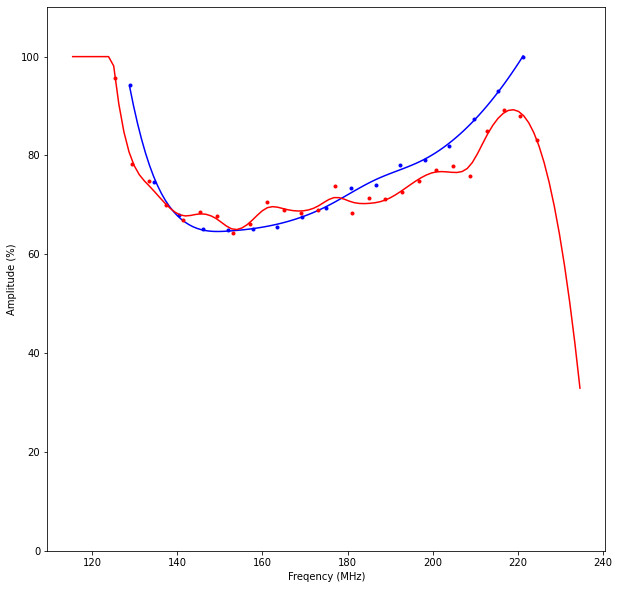

In [157]:
from scipy.interpolate import UnivariateSpline

freqsD0,ampD0 = np.load('ampD0_calibration.npy')
# freqsD1,ampD1 = np.load('ampD1_calibration.npy')

print(ampD0.mean(), ampD1.mean())

interpAmpD0 = UnivariateSpline(freqsD0,ampD0, k = 3, s = 5)
def fAmpD0(freq):
    return interpAmpD0(freq)*100/ampD0[-1]

xs = np.linspace(freqsD0[0],freqsD0[-1],100)

plt.plot(freqsD0,ampD0,'b.')
# plt.plot(xs, interpAmpD0(xs), 'b-')
plt.plot(xs, fAmpD0(xs), 'b-')
plt.xlabel('Freqency (MHz)')
plt.ylabel('Amplitude (%)')
plt.ylim([0,100])
# plt.show()
np.save('ampD0_calibration.npy', [freqsD0,ampD0], allow_pickle=True)

interpAmpD1 = UnivariateSpline(freqsD1,ampD1, k = 3, s = 25)
def fAmpD1(freq):
    amp = interpAmpD1(freq)
    return np.where(amp<100,amp, 100)

xs = np.linspace(freqsD1[0]-10,freqsD1[-1]+10,100)

plt.plot(freqsD1,ampD1,'r.')
# plt.plot(xs, interpAmpD1(xs), 'r-')
plt.plot(xs, fAmpD1(xs), 'r-')
plt.xlabel('Freqency (MHz)')
plt.ylabel('Amplitude (%)')
plt.ylim([0,110])
plt.show()
np.save('ampD1_calibration.npy', [freqsD1,ampD1], allow_pickle=True)

In [15]:
original_stdout = sys.stdout # Save a reference to the original standard output
sys.stdout = original_stdout # Reset the standard output to its original value

In [16]:
original_stdout = sys.stdout # Save a reference to the original standard output

with open('211101_3x3_rectMoves.gmoogScript', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    
    for ind in tone_inds0_square:
        print('set', "DAC"+str(0+DACoffset), ind, ampD0_square[ind], str(freqsD0_square[ind]) + '+xoff', phase_degs0_square[ind])

    print()

    for ind in tone_inds1_square:
        print('set', "DAC"+str(1+DACoffset), ind, ampD1_square[ind], str(freqsD1_square[ind]) + '+yoff', phase_degs1_square[ind])

    print() 

    for ind in tone_inds0:
        print('setmove', '0', "DAC"+str(0+DACoffset), ind, 0, 0,
              ampD0[ind], 'ampRate' if ampD0[ind]>ampD0_square[ind] else '-ampRate',
              str(freqsD0[ind]) + '+xoff', 'moveRate' if freqsD0[ind]>freqsD0_square[ind] else '-moveRate',
              phase_degs0[ind])

    print()

    for ind in tone_inds1:
        print('setmove', '0', "DAC"+str(1+DACoffset), ind, 0, 0,
              ampD1[ind], 'ampRate' if ampD1[ind]>ampD1_square[ind] else '-ampRate',
              str(freqsD1[ind]) + '+yoff', 'moveRate' if freqsD1[ind]>freqsD1_square[ind] else '-moveRate',
              phase_degs1[ind])
    print()
    
    sys.stdout = original_stdout # Reset the standard output to its original value

In [14]:
(roisums.reshape((numtones1,numtones0))[::-1,:])/roisums.max()

array([[0.8913738 , 0.88498403, 0.87699681, 0.86900958, 0.86421725,
        0.88338658, 0.89297125, 0.88977636, 0.84185304, 0.81789137,
        0.90095847, 0.89616613, 0.93610224, 0.9313099 , 0.83865815,
        0.80990415],
       [0.9201278 , 0.87060703, 0.88658147, 0.83865815, 0.86900958,
        0.92492013, 0.92651757, 0.93769968, 0.91853035, 0.88178914,
        0.85463259, 0.8514377 , 0.9057508 , 0.92971246, 0.87539936,
        0.86421725],
       [0.90894569, 0.87699681, 0.89936102, 0.87539936, 0.85942492,
        0.88817891, 0.89297125, 0.92651757, 0.91533546, 0.91533546,
        0.87060703, 0.82907348, 0.8370607 , 0.89936102, 0.9057508 ,
        0.88338658],
       [0.92332268, 0.86421725, 0.88658147, 0.86900958, 0.94089457,
        0.88019169, 0.89456869, 0.92172524, 0.84984026, 0.89936102,
        0.89936102, 0.84185304, 0.85942492, 0.83067093, 0.88178914,
        0.88178914],
       [0.89616613, 0.87699681, 0.86421725, 0.88817891, 0.90894569,
        0.91373802, 0.91054313, 

In [11]:
# freqsD0 = freqsD0 + spacingD0/5
# freqsD1 = freqsD1 + spacingD1/5

if double:
    for ind in tone_inds0:
        print('set', "DAC"+str(0+DACoffset), ind, amp100_0[ind], freqsD0[ind], phase_degs0[ind])

    print()

    for ind in tone_inds1:
        print('set', "DAC"+str(1+DACoffset), ind, amp100_1[ind], freqsD1[ind], phase_degs1[ind])
    
    print()
    
    for ind in tone_inds0:
        print('set', "DAC"+str(0+DACoffset), ind + np.max(tone_inds0) + 1, ampD0[ind], freqsD0[ind], phase_degs0[ind])

    print()

    for ind in tone_inds1:
        print('set', "DAC"+str(1+DACoffset), ind + np.max(tone_inds1) + 1, ampD1[ind], freqsD1[ind], phase_degs1[ind])

else:    
    for ind in tone_inds0:
        print('set', "DAC"+str(0+DACoffset), ind, ampD0[ind], freqsD0[ind], phase_degs0[ind])

    print()

    for ind in tone_inds1:
        print('set', "DAC"+str(1+DACoffset), ind, ampD1[ind], freqsD1[ind], phase_degs1[ind])

set DAC0 0 67.45303124999997 135.77410930765086 11.2
set DAC0 1 63.41653124999997 141.67089473329742 45.0
set DAC0 2 60.30703124999999 147.56768015894397 101.2
set DAC0 3 61.80253125000001 153.46446558459053 180.0
set DAC0 4 61.503531250000016 159.36125101023708 281.2
set DAC0 5 61.65403125000001 165.25803643588364 45.0
set DAC0 6 63.79703125000004 171.1548218615302 191.2
set DAC0 7 65.20053125000003 177.05160728717675 0.0
set DAC0 8 67.72353125000005 182.9483927128233 191.2
set DAC0 9 70.58053124999998 188.84517813846986 45.0
set DAC0 10 71.56303124999995 194.74196356411642 281.2
set DAC0 11 73.10353124999997 200.63874898976297 180.0
set DAC0 12 77.66953125 206.53553441540953 101.2
set DAC0 13 82.77003124999997 212.43231984105608 45.0
set DAC0 14 89.32553125000003 218.32910526670264 11.2
set DAC0 15 99.82153124999999 224.2258906923492 0.0

set DAC1 0 85.63246874999996 130.77410930765086 11.2
set DAC1 1 80.21596875000002 136.67089473329742 45.0
set DAC1 2 74.03096875000003 142.56768015

In [21]:
10*np.log10((/.8)**2)

1.4926723659380823

In [ ]:
#
# code for balancing at 813

#
#

%autoreload

plt.rcParams['figure.figsize'] = (10,10)

# Starting point for generating tones

numtones0 = 16
numtones1 = 20

bgoff = (165, 165)

DACoffset = 2
amp_guessD0 = 70
amp_guessD1 = 70

lincorr0 = 0
lincorr1 = 0

freqcenterD0 = 180
spacingD0 = 5.1*0.6377
freqcenterD1 = 190
spacingD1 = 4.2*0.6377

# freqcenterD0 = 185+4*3-11 - 8.4
# spacingD0 = 4
# freqcenterD1 = 185+4.5*3-2*3.25 + 4.5 - 7
# spacingD1 = 4.5

# freqcenterD0 = 180.2888
# spacingD0 = 3.1888
# freqcenterD1 = 189.6888
# spacingD1 = 3.5077

# DACoffset = 0 # 0: 515 rail, 2: 813 rail

# freqcenterD0 = 180
# spacingD0 = 4.6
# freqcenterD1 = 180
# spacingD1 = 4.6

# amp_guessD0 = 90
# amp_guessD1 = 90

# offset = 1.3
double = False #BE VERY CAREFUL - CAN QUADRUPLE EXPECTED OUTPUT POWER IF SET TO TRUE.
cam = 0
exposure = 50


#####################
# if len(roisums) > numtones:
#     roisums = roisums[::2]

tone_inds0 = np.arange(numtones0)
tone_inds1 = np.arange(numtones1)

freqsD0 = np.arange(freqcenterD0-spacingD0*(numtones0-1)/2, freqcenterD0+spacingD0*numtones0/2, spacingD0)
freqsD1 = np.arange(freqcenterD1-spacingD1*(numtones1-1)/2, freqcenterD1+spacingD1*numtones1/2, spacingD1)

phases0 = np.pi*((tone_inds0+1)**2)/(numtones0)
phases1 = np.pi*((tone_inds1+1)**2)/(numtones1)

phase_degs0 = np.round(phases0*180/np.pi%360, 1)
phase_degs1 = np.round(phases1*180/np.pi%360, 1)

ampscale = .001

init_ampsD0 = np.ones(numtones0)*amp_guessD0 + (np.arange(numtones0)-numtones0/2)*lincorr0
init_ampsD1 = np.ones(numtones1)*amp_guessD1 + (np.arange(numtones1)-numtones1/2)*lincorr1

ampD0 = init_ampsD0
ampD1 = init_ampsD1
err = 75

seq0 = c_float * numtones0
seq1 = c_float * numtones1

gmoog.zeroAll()

if double:
    amp100 = np.ones(numtones)*100
    seq = c_float * (2 * numtones)
    freqsetDD0 = np.concatenate((freqsD0,freqsD0))
    freqsetDD1 = np.concatenate((freqsD1,freqsD1))

    ampsetDD0 = np.concatenate((amp100, ampD0))
    ampsetDD1 = np.concatenate((amp100, ampD1))

    phasesetD0 = np.concatenate((phase_degs0, phase_degs0))
    phasesetD1 = np.concatenate((phase_degs1, phase_degs1))
    gmoog.setDAC(0+DACoffset, 2*numtones, seq(*freqsetDD0), seq(*ampsetDD0), seq(*phasesetD0))
    gmoog.setDAC(1+DACoffset, 2*numtones, seq(*freqsetDD1), seq(*ampsetDD1), seq(*phasesetD1))
else:
    gmoog.setDAC(0+DACoffset, len(freqsD0), seq0(*freqsD0), seq0(*ampD0), seq0(*phase_degs0))
    gmoog.setDAC(1+DACoffset, len(freqsD1), seq1(*freqsD1), seq1(*ampD1), seq1(*phase_degs1))

gmoog.endMessage()

time.sleep(.2)

capture_image(cameraID = cam, exposure = exposure)
img = np.loadtxt('tmp_img.txt', dtype=int);
imgc, crop_coords = klib.imagutil.crop(img, sigma = 2, offset = 10, coords = True, pad = 2, plots = True)
masks = getMasks(imgc, fftN = 5000, N = [numtones0, numtones1], wmask = 16)*2

if double:
    for ind in tone_inds0:
        print('set', "DAC"+str(0+DACoffset), ind, amp100[ind], freqsD0[ind], phase_degs0[ind])

    print()

    for ind in tone_inds1:
        print('set', "DAC"+str(1+DACoffset), ind, amp100[ind], freqsD1[ind], phase_degs1[ind])
    
    print()
    
    for ind in tone_inds0:
        print('set', "DAC"+str(0+DACoffset), ind + np.max(tone_inds) + 1, ampD0[ind], freqsD0[ind], phase_degs0[ind])

    print()

    for ind in tone_inds1:
        print('set', "DAC"+str(1+DACoffset), ind + np.max(tone_inds) + 1, ampD1[ind], freqsD1[ind], phase_degs1[ind])

else:    
    for ind in tone_inds0:
        print('set', "DAC"+str(0+DACoffset), ind, ampD0[ind], freqsD0[ind], phase_degs0[ind])

    print()

    for ind in tone_inds1:
        print('set', "DAC"+str(1+DACoffset), ind, ampD1[ind], freqsD1[ind], phase_degs1[ind])

In [ ]:
%autoreload

plt.rcParams['figure.figsize'] = (10,10)

# Starting point for generating tones

numtones = 18
bgoff = (165, 165)

DACoffset = 2 
amp_guessD0 = 70
amp_guessD1 = 70

lincorr0 = 1.5
lincorr1 = 1

freqcenterD0 = 180+2
spacingD0 = 4.6*0.6377
freqcenterD1 = 180+9.7
spacingD1 = 4.6*0.6377

# freqcenterD0 = 185+4*3-11 - 8.4
# spacingD0 = 4
# freqcenterD1 = 185+4.5*3-2*3.25 + 4.5 - 7
# spacingD1 = 4.5

# freqcenterD0 = 180.2888
# spacingD0 = 3.1888
# freqcenterD1 = 189.6888
# spacingD1 = 3.5077

# DACoffset = 0 # 0: 515 rail, 2: 813 rail

# freqcenterD0 = 180
# szpacingD0 = 4.6
# freqcenterD1 = 180
# spacingD1 = 4.6

# amp_guessD0 = 90
# amp_guessD1 = 90

# offset = 1.3
double = False #BE VERY CAREFUL - CAN QUADRUPLE EXPECTED OUTPUT POWER IF SET TO TRUE.
cam = 0
exposure = 50


#####################
# if len(roisums) > numtones:
#     roisums = roisums[::2]

tone_inds = np.arange(numtones)

freqsD0 = np.arange(freqcenterD0-spacingD0*(numtones-1)/2, freqcenterD0+spacingD0*numtones/2, spacingD0)
freqsD1 = np.arange(freqcenterD1-spacingD1*(numtones-1)/2, freqcenterD1+spacingD1*numtones/2, spacingD1)

phases = np.pi*((tone_inds+1)**2)/(numtones)
phase_degs = np.round(phases*180/np.pi%360, 1)

ampscale = .001

init_ampsD0 = np.ones(numtones)*amp_guessD0 + (np.arange(numtones)-numtones/2)*lincorr0
init_ampsD1 = np.ones(numtones)*amp_guessD1 + (np.arange(numtones)-numtones/2)*lincorr1

ampD0 = init_ampsD0
ampD1 = init_ampsD1
err = 75

seq = c_float * numtones

gmoog.zeroAll()

if double:
    amp100 = np.ones(numtones)*100
    seq = c_float * (2 * numtones)
    freqsetDD0 = np.concatenate((freqsD0,freqsD0))
    freqsetDD1 = np.concatenate((freqsD1,freqsD1))

    ampsetDD0 = np.concatenate((amp100, ampD0))
    ampsetDD1 = np.concatenate((amp100, ampD1))

    phasesetD = np.concatenate((phase_degs,phase_degs))
    gmoog.setDAC(0+DACoffset, 2*numtones, seq(*freqsetDD0), seq(*ampsetDD0), seq(*phasesetD))
    gmoog.setDAC(1+DACoffset, 2*numtones, seq(*freqsetDD1), seq(*ampsetDD1), seq(*phasesetD))
else:
    gmoog.setDAC(0+DACoffset, len(freqsD0), seq(*freqsD0), seq(*ampD0), seq(*phase_degs))
    gmoog.setDAC(1+DACoffset, len(freqsD0), seq(*freqsD1), seq(*ampD1), seq(*phase_degs))

gmoog.endMessage()

time.sleep(.2)

capture_image(cameraID = cam, exposure = exposure)
img = np.loadtxt('tmp_img.txt', dtype=int);
imgc, crop_coords = klib.imagutil.crop(img, sigma = 2, offset = 10, coords = True, pad = 2)
masks = getMasks(imgc, fftN = 5000, N = numtones, wmask = 16)*2

if double:
    for ind in tone_inds:
        print('set', "DAC"+str(0+DACoffset), ind, amp100[ind], freqsD0[ind], phase_degs[ind])

    print()

    for ind in tone_inds:
        print('set', "DAC"+str(1+DACoffset), ind, amp100[ind], freqsD1[ind], phase_degs[ind])
    
    print()
    
    for ind in tone_inds:
        print('set', "DAC"+str(0+DACoffset), ind + np.max(tone_inds) + 1, ampD0[ind], freqsD0[ind], phase_degs[ind])

    print()

    for ind in tone_inds:
        print('set', "DAC"+str(1+DACoffset), ind + np.max(tone_inds) + 1, ampD1[ind], freqsD1[ind], phase_degs[ind])

else:    
    for ind in tone_inds:
        print('set', "DAC"+str(0+DACoffset), ind, ampD0[ind], freqsD0[ind], phase_degs[ind])

    print()

    for ind in tone_inds:
        print('set', "DAC"+str(1+DACoffset), ind, ampD1[ind], freqsD1[ind], phase_degs[ind])